# Debias Compas algorithm classifier

## The objective of "Debiasing the COMPAS Algorithm Classifier" involves applying fairness interventions to the COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) risk assessment tool to reduce or eliminate biases inherent in its predictions. COMPAS is widely used in the criminal justice system in the United States to assess the likelihood of a defendant becoming a recidivist, i.e., reoffending in the future. However, analyses, including a notable investigation by ProPublica, have raised concerns about potential biases in the COMPAS tool, particularly racial biases.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # 
import seaborn as sn
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import StandardDataset as Dataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

pip install 'aif360[LawSchoolGPA]'


In [23]:
df_compas_bias = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

In [24]:
columns_to_drop = ['id', 'name', 'first', 'last', 'compas_screening_date', 'dob', 'age', 'c_jail_in', 'c_jail_out', 
                   'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_charge_desc', 'days_b_screening_arrest', 
                   'decile_score', 'r_case_number', 'r_days_from_arrest', 'r_offense_date', 'c_days_from_compas', 
                   'r_charge_degree', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'priors_count.1', 'violent_recid', 
                   'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 
                   'type_of_assessment', 'decile_score.1', 'score_text', 'is_recid', 'v_type_of_assessment', 
                   'screening_date', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 
                   'event']

df_compas_bias_w = df_compas_bias.drop(columns=[col for col in columns_to_drop if col in df_compas_bias.columns])


In [25]:
### Keep only whites and blacks
race_map = {'African-American':0, 'Caucasian':1, 'Asian':2, 'Hispanic':3, 'Native American':4, 'Other':5
}

df_compas_bias_w['race'] = df_compas_bias_w['race'].apply(lambda x: race_map[x])
df_compas_bias_w = df_compas_bias_w[(df_compas_bias_w.race == 0.) | (df_compas_bias_w.race == 1.)]

# Map age categories to numeric values
age_map = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
df_compas_bias_w['age_cat'] = df_compas_bias_w['age_cat'].map(age_map)

# Convert sex to binary values (Male: 0, Female: 1)
sex_map = {'Male': 0, 'Female': 1}
df_compas_bias_w['sex'] = df_compas_bias_w['sex'].map(sex_map)

# Convert charge degree to binary values (F: 1, M: 0)
charge_degree_map = {'F': 1., 'M': 0.}
df_compas_bias_w['c_charge_degree'] = df_compas_bias_w['c_charge_degree'].map(charge_degree_map)

In [26]:

# Calculate duration in days and drop the original 'end' and 'start' columns
df_compas_bias_w['duration'] = (df_compas_bias_w['end'] - df_compas_bias_w['start'])


In [29]:


# Separate features (X) and target variable (y)
X = df_compas_bias_w.drop(columns=['two_year_recid']).values
y = df_compas_bias_w['two_year_recid'].values

# Rescale the features for better performance
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Display the first few rows of the modified DataFrame
df_compas_bias_w.head()

#erase start and end

df_compas_bias_w = df_compas_bias_w.drop(columns=['start', 'end'])


In [52]:
#check variables names from X array

df_compas_bias_w.columns



Index(['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'two_year_recid',
       'duration'],
      dtype='object')

In [45]:
# Separate features (X) and target variable (y)
X = df_compas_bias_w.drop(columns=['two_year_recid']).values
y = df_compas_bias_w['two_year_recid'].values

df_compas_bias_w.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,duration
1,0,1,0.0,0,0,0,0,1.0,1,150
2,0,0,0.0,0,0,1,4,1.0,1,63
3,0,0,0.0,0,1,0,1,1.0,0,1174
6,0,1,1.0,0,0,0,14,1.0,1,35
8,1,1,1.0,0,0,0,0,0.0,0,745


## Predicting whether an individual will recidivate (two-year recidivism)

In [38]:
### Split to train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Fit logistic regression and print accuracy
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy =", np.round(acc, 3))

Accuracy = 0.874


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


# Precision
precision = precision_score(y_test, y_pred)
print("Precision =", np.round(precision, 3))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall =", np.round(recall, 3))

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score =", np.round(f1, 3))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Precision = 0.851
Recall = 0.889
F1 Score = 0.869
Confusion Matrix:
 [[838 136]
 [ 97 774]]


In [31]:
print("Percentage of recidivism in test set:", np.round(np.mean(y_test), 3))


Percentage of recidivism in test set: 0.471


## Ratio of African-American to Caucasians on the original data

In [32]:
# Calculate the ratio of African-American to Caucasian prisoners
afr_am_to_whites_ratio = (df_compas_bias_w['race'] == 0.).sum() / (df_compas_bias_w['race'] == 1.).sum()

# Print the rounded ratio
print("Black to white prisoners ratio:", round(afr_am_to_whites_ratio, 2))


Black to white prisoners ratio: 1.51


1.51 indicates that for every Caucasian prisoner, there are approximately 1.51 African-American prisoners.


In [34]:
#check demographic parity in the dataset df_compas_bias_w

#describe the dataset

df_compas_bias_w.describe()


,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,duration
count,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000
mean,0.198211,1.003902,0.399024,0.070732,0.098699,0.117886,3.699837,0.654797,0.466179,526.823740
std,0.398685,0.655724,0.489738,0.436621,0.504829,0.517938,5.028782,0.475473,0.498895,399.607226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-256.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,466.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,894.000000
max,1.000000,2.000000,1.000000,10.000000,13.000000,17.000000,38.000000,1.000000,1.000000,1186.000000


## Ratio of African-American to Caucasians on the predicted outcomes

In [41]:
# Identifying African-American and Caucasian individuals in the test set
afr_am = (X_test[:, 2] == 0)
white = (X_test[:, 2] == 1)

# Predictions for African-American and Caucasian individuals
pred_afr_am = y_pred[afr_am]
pred_white = y_pred[white]

# Calculating ratios
afr_am_to_whites_ratio = afr_am.sum() / white.sum()
predicted_reoffense_afr_am_to_whites_ratio = pred_afr_am.sum() / pred_white.sum()

# Printing the ratios
print("Black to white prisoners ratio:", round(afr_am_to_whites_ratio, 2))
print("Predicted reoffense blacks to whites ratio:", round(predicted_reoffense_afr_am_to_whites_ratio, 2))


Black to white prisoners ratio: 1.51
Predicted reoffense blacks to whites ratio: 2.15


## Model predicts African-American prisoners are 2.15 times more likely to reoffend than Caucasian prisoners. This ratio is higher than the actual ratio of African-American to Caucasian prisoners, indicating a potential bias in the predictions towards expecting higher recidivism among African-American individuals.

In [54]:
# Import the necessary library
import pandas as pd

# Assuming clf is your trained LogisticRegression model
coefficients = clf.coef_[0]

# Check if the model includes an intercept
intercept = clf.intercept_[0] if clf.intercept_ is not None else None

# Extract feature names from the DataFrame
features = df_compas_bias_w.drop(columns=['two_year_recid']).columns

# If there are more coefficients than feature names, check for one-hot encoded features
if len(coefficients) != len(features):
    print("Number of coefficients and features do not match. Check for one-hot encoded features.")

# Creating a DataFrame for coefficients and features
df_coef = pd.DataFrame({'Feature': features, 'Coefficient': coefficients[:len(features)]})

# If there is an intercept, add it to the DataFrame
if intercept is not None:
    intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept]})
    df_coef = pd.concat([intercept_df, df_coef], ignore_index=True)

# Display the DataFrame
print(df_coef)


Number of coefficients and features do not match. Check for one-hot encoded features.
           Feature  Coefficient
0        Intercept     4.081855
1              sex    -0.166619
2          age_cat    -0.711554
3             race    -0.235625
4    juv_fel_count     0.865515
5   juv_misd_count     0.457209
6  juv_other_count     0.824682
7     priors_count     1.913060
8  c_charge_degree    -0.253902
9         duration     2.310405


- Sex (-0.166619): Suggests females (if coded as 1) are less likely to recidivate compared to males.

- Age Category (-0.711554): Implies older individuals are less likely to recidivate.

- Race (-0.235625): Indicates Caucasians (if coded as 1) are less likely to recidivate compared to African-Americans.

- Juvenile Felony Count (0.865515): More juvenile felony counts increase the likelihood of recidivism.

- Juvenile Misdemeanor Count (0.457209): Higher juvenile misdemeanor counts are associated with increased recidivism.

- Juvenile Other Count (0.824682): An increase in other juvenile counts raises the likelihood of recidivism.

- Priors Count (1.913060): A higher number of prior offenses significantly increases the likelihood of recidivism.

- Charge Degree (-0.253902): Individuals with misdemeanors (if coded as 0) are less likely to recidivate compared to those with felonies.

- Duration (2.310405): Longer durations, measured in days, are associated with a higher likelihood of recidivism.

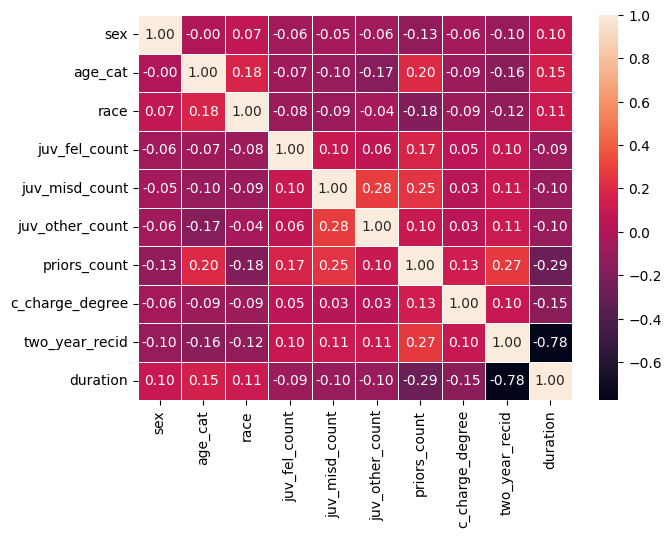

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_compas_bias_w.corr()

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(7, 5))  # You can adjust these dimensions as needed

# Draw the heatmap with the correlation matrix and annotations
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)

# Show the plot
plt.show()

There is a strong negative correlation between two_year_recid and duration, suggesting longer durations are associated with lower recidivism within two years.
two_year_recid is moderately positively correlated with priors_count, indicating a higher likelihood of recidivism among individuals with more prior offenses.
There are slight positive correlations among juvenile offense counts (juv_fel_count, juv_misd_count, juv_other_count), and between age_cat and race, indicating potential, albeit weak, relationships between these variables.
There is also a slight positive correlation between priors_count and c_charge_degree, which may suggest that individuals with more priors are often charged with more severe offenses.

# Disparate Impact Repairing

### Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups

#### Disparate Impact is a fairness metric used to assess the equality of outcomes between two distinct groups: an unprivileged group and a privileged group. It measures the ratio of the proportion of individuals receiving favorable outcomes in the unprivileged group to that in the privileged group.

$$
\frac{\Pr(Y=1|D=\text{unprivileged})}{\Pr(Y=1|D=\text{privileged})}
$$

/var/folders/q3/ztffc4r10tv5h4pftjr2qw0r0000gn/T/ipykernel_17179/254269351.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(unprivileged['two_year_recid'], hist=False, label='Unprivileged (African-American)')
/var/folders/q3/ztffc4r10tv5h4pftjr2qw0r0000gn/T/ipykernel_17179/254269351.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github

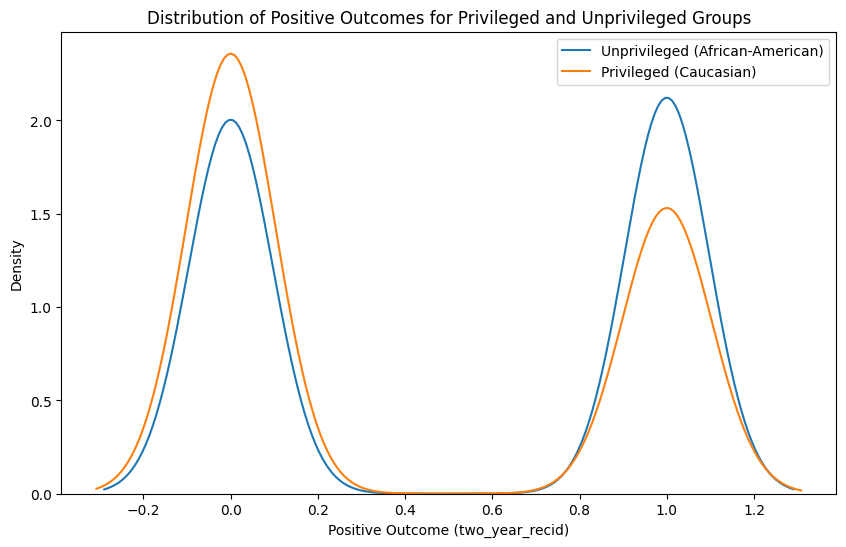

In [67]:
# Filter the DataFrame into privileged and unprivileged groups
unprivileged = df_compas_bias_w[df_compas_bias_w['race'] == 0]
privileged = df_compas_bias_w[df_compas_bias_w['race'] == 1]

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the distribution for the unprivileged group
sns.distplot(unprivileged['two_year_recid'], hist=False, label='Unprivileged (African-American)')

# Plot the distribution for the privileged group
sns.distplot(privileged['two_year_recid'], hist=False, label='Privileged (Caucasian)')

# Add title and labels
plt.title('Distribution of Positive Outcomes for Privileged and Unprivileged Groups')
plt.xlabel('Positive Outcome (two_year_recid)')
plt.ylabel('Density')

# Show the plot
plt.legend()
plt.show()

In [ ]:
#Plot the distribution of Feature for each of the two groups and visually see this disparity 

# Import the necessary libraries

import matplotlib.pyplot as plt

# Set up the matplotlib figure with a larger size

plt.figure(figsize=(7, 5))  # You can adjust these dimensions as needed

# Plot the distribution of scores for African-Americans df: df_compas_bias_w






In [71]:
protected = 'race' #We chose race as the protected attribute because we are interested in the disparity between African-Americans and Caucasians

# Create a StandardDataset object
df_protected = Dataset(df_compas_bias_w, #The dataset
             label_name='two_year_recid', #The label or target variable that we want to predict
             favorable_classes=[0], #The class we want to consider favorable (0 means no recidivism)
             protected_attribute_names=[protected], #The attribute we want to test for disparity
             privileged_classes=[[1]], categorical_features=[],   # 0 -> Black, 1 -> White to match the order of our dataset
             features_to_keep=['race', 'priors_count', 'duration']) #The features we want to keep in the dataset because they are relevant for our model


cd

               instance weights            features                        \
                                protected attribute                         
                                               race priors_count duration   
instance names                                                              
1                           1.0                 0.0          0.0    150.0   
2                           1.0                 0.0          4.0     63.0   
3                           1.0                 0.0          1.0   1174.0   
6                           1.0                 1.0         14.0     35.0   
8                           1.0                 1.0          0.0    745.0   
...                         ...                 ...          ...      ...   
7207                        1.0                 0.0          0.0    529.0   
7208                        1.0                 0.0          0.0    169.0   
7209                        1.0                 0.0          0.0    859.0   

In [72]:
from sklearn.preprocessing import MinMaxScaler #We will use MinMaxScaler to rescale our features

scaler = MinMaxScaler(copy=False) #We create a scaler object

# Splitting the dataset into test and train sets like we did before
test, train = df_protected.split([0.33], seed=42) #We use a seed to make sure we get the same split every time

# Fitting the scaler on the training features and transforming the training features using the same scaler
train.features = scaler.fit_transform(train.features) #We fit the scaler on the training features

# Transforming the test features using the same scaler as the one fitted on the training features
test.features = scaler.transform(test.features) #We transform the test features using the same scaler

# Getting the index of the protected attribute in the feature names list
index = train.feature_names.index(protected) #We get the index of the protected attribute in the feature names list



# Repair levels between 0 and 1

The "repair level" parameter quantifies the extent to which you want to adjust the dataset to correct for disparities between privileged and unprivileged groups.

In [75]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric

# Initialize a list to store the disparate impact values
DIs = []

# Iterate over each level of repair
for level in tqdm(np.linspace(0., 1., 11)):
    # Initialize DisparateImpactRemover with the current level
    di = DisparateImpactRemover(repair_level=level) #We initialize the DisparateImpactRemover with the current level
    # Fit and transform the training data
    train_repd = di.fit_transform(train) #We fit and transform the training data
    # Transform the test data (do not fit the test data)
    test_repd = di.fit_transform(test) #We transform the test data (do not fit the test data)
    
    # Remove the protected attribute before training the model
    X_tr = np.delete(train_repd.features, index, axis=1) #We remove the protected attribute before training the model
    X_te = np.delete(test_repd.features, index, axis=1) #We remove the protected attribute before training the model
    y_tr = train_repd.labels.ravel() #We get the labels for the training set
    
    # Initialize and fit the logistic regression model
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear') #We initialize and fit the logistic regression model with class_weight='balanced' to account for the imbalance in the dataset
    lmod.fit(X_tr, y_tr) #We fit the model
    
    # Predict on the test set and copy the results to a new dataset
    test_repd_pred = test_repd.copy() #We predict on the test set and copy the results to a new dataset
    test_repd_pred.labels = lmod.predict(X_te) #We predict on the test set and copy the results to a new dataset

    # Calculate and store the disparate impact
    p = [{protected: 1}] #We calculate and store the disparate impact for the privileged group (in our case Caucasians)
    u = [{protected: 0}] #We calculate and store the disparate impact for the unprivileged group (in our case African-Americans)
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u) #We calculate and store the disparate impact for the privileged and unprivileged groups
    DIs.append(cm.disparate_impact()) #We calculate and store the disparate impact for the privileged and unprivileged groups



100%|██████████| 11/11 [00:01<00:00,  9.49it/s]


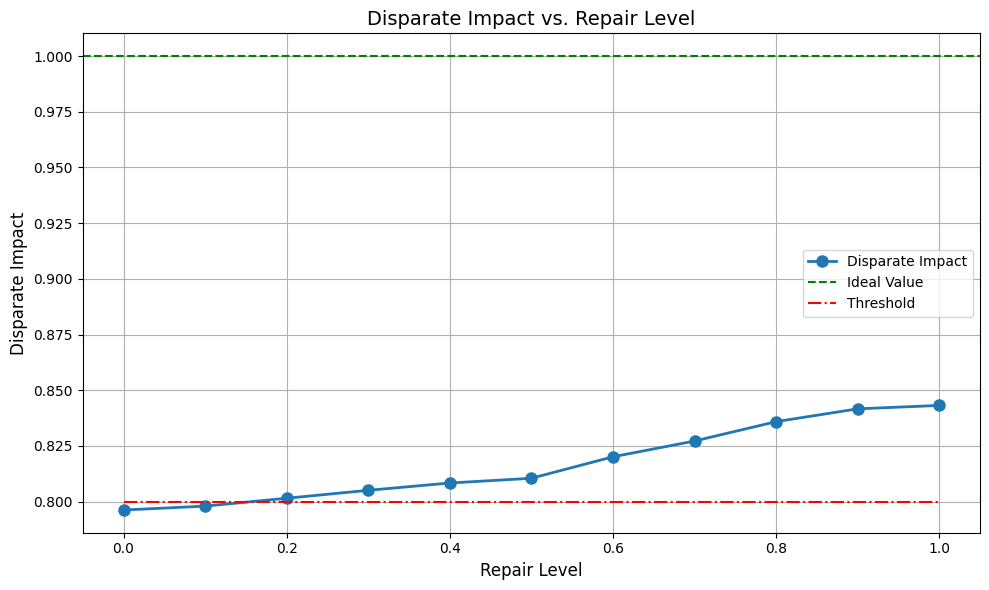

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming DIs is your list of disparate impact values
repair_levels = np.linspace(0., 1., 11)

DIs = DIs[:11] 

plt.figure(figsize=(10, 6))
plt.plot(repair_levels, DIs, marker='o', markersize=8, linewidth=2, label='Disparate Impact')

plt.title('Disparate Impact vs. Repair Level', fontsize=14)
plt.xlabel('Repair Level', fontsize=12)
plt.ylabel('Disparate Impact', fontsize=12)

plt.axhline(y=1.0, color='g', linestyle='--', label='Ideal Value')
plt.plot([0, 1], [0.8, 0.8], 'r', linestyle='-.', label='Threshold')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




The graph illustrates the efficacy of the Disparate Impact Remover at different repair levels for reducing racial bias within the context of predicting two-year recidivism. As the repair level increases from 0 (no adjustment) to 1 (full adjustment), the disparate impact metric approaches 1.0, which signifies fair treatment between races; each blue dot is a data point that shows how the fairness of the model, as measured by the disparate impact, changes as we apply different levels of bias mitigation.  Initially, with no repair, the metric is close to 0.8, indicating substantial bias against the unprivileged group (likely African-Americans). With full repair, the bias is reduced, but not entirely eliminated, suggesting some residual unfairness remains or that the repair cannot fully compensate for the existing disparities within the data. The graph underscores the challenge of achieving complete fairness, as represented by the elusive ideal disparate impact value of 1.0, even as efforts are made to correct for bias in predictive modeling for criminal justice.

# Predict recidivism blacks to whites ratio with the repair

In [79]:
# Predict on test using only the features at indices -3 and -1
y_pred = lmod.predict(X_test[:, [-3, -1]])

# Boolean masks for African-American and Caucasian individuals
afr_am_mask = (X_test[:, 2] == 0)
white_mask = (X_test[:, 2] == 1)

# Predictions for African-American and Caucasian individuals
pred_afr_am = y_pred[afr_am_mask]
pred_white = y_pred[white_mask]

# Calculating the ratio of predicted reoffenses
predicted_reoffense_afr_am_to_whites_ratio = pred_afr_am.sum() / pred_white.sum()

# Printing the predicted reoffense ratio
print("Predicted reoffense blacks to whites ratio:", np.round(predicted_reoffense_afr_am_to_whites_ratio, 2))


Predicted reoffense blacks to whites ratio: 2.04


## Ratio dropped from 2.15 to 2.04. Reparation has worked. 

In [81]:
from aif360.metrics import BinaryLabelDatasetMetric

# Define unprivileged and privileged groups. Let's assume these are defined somewhere in the code.

privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]


# Initialize the metric for the original training dataset
metric_orig_train = BinaryLabelDatasetMetric(train, # train from protected dataset
                                             unprivileged_groups=unprivileged_groups, # Consideres to be at disadvantage (e.g., Blacks) 
                                             privileged_groups=privileged_groups) # Considered to be at an advantage (e.g., Caucasians)

# Print the difference in mean outcomes between unprivileged and privileged groups
mean_diff = metric_orig_train.mean_difference() # difference in probabilities of favorable outcomes between the privileged and unprivileged groups.
#A positive value indicates a bias in favor of the privileged group, while a negative value indicates a bias against the unprivileged group.
print("Difference in mean outcomes between blacks and whites = %f" % mean_diff)


Difference in mean outcomes between blacks and whites = -0.125928


In [83]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train)
transf_train = RW.transform(train)

Reweighing process to ensure that the total sum of instance weights for the transformed training dataset (transf_train.instance_weights.sum()) is approximately equal to the total sum of instance weights for the original training dataset (train.instance_weights.sum()). The check is done using an absolute difference and comparing it against a small number, 1e-6, to account for any minor floating-point arithmetic discrepancies.



In [84]:
### Testing 
np.abs(transf_train.instance_weights.sum()-train.instance_weights.sum())<1e-6

True

# Difference in mean outcomes with the transformed data

The result True indicates that the reweighing algorithm is functioning as intended in this regard: it's modifying individual instance weights to address disparities without changing the overall weight sum. This is important to ensure that the dataset's overall statistical properties remain consistent while individual instances are weighted differently to mitigate bias.

In [89]:
metric_orig_train = BinaryLabelDatasetMetric(train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
orig_mean_difference = metric_orig_train.mean_difference()


metric_transf_train = BinaryLabelDatasetMetric(transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
transf_mean_difference = metric_transf_train.mean_difference()

print("Difference in mean outcomes between transformed blacks and whites = %f" % metric_transf_train.mean_difference())

Difference in mean outcomes between transformed blacks and whites = -0.000000


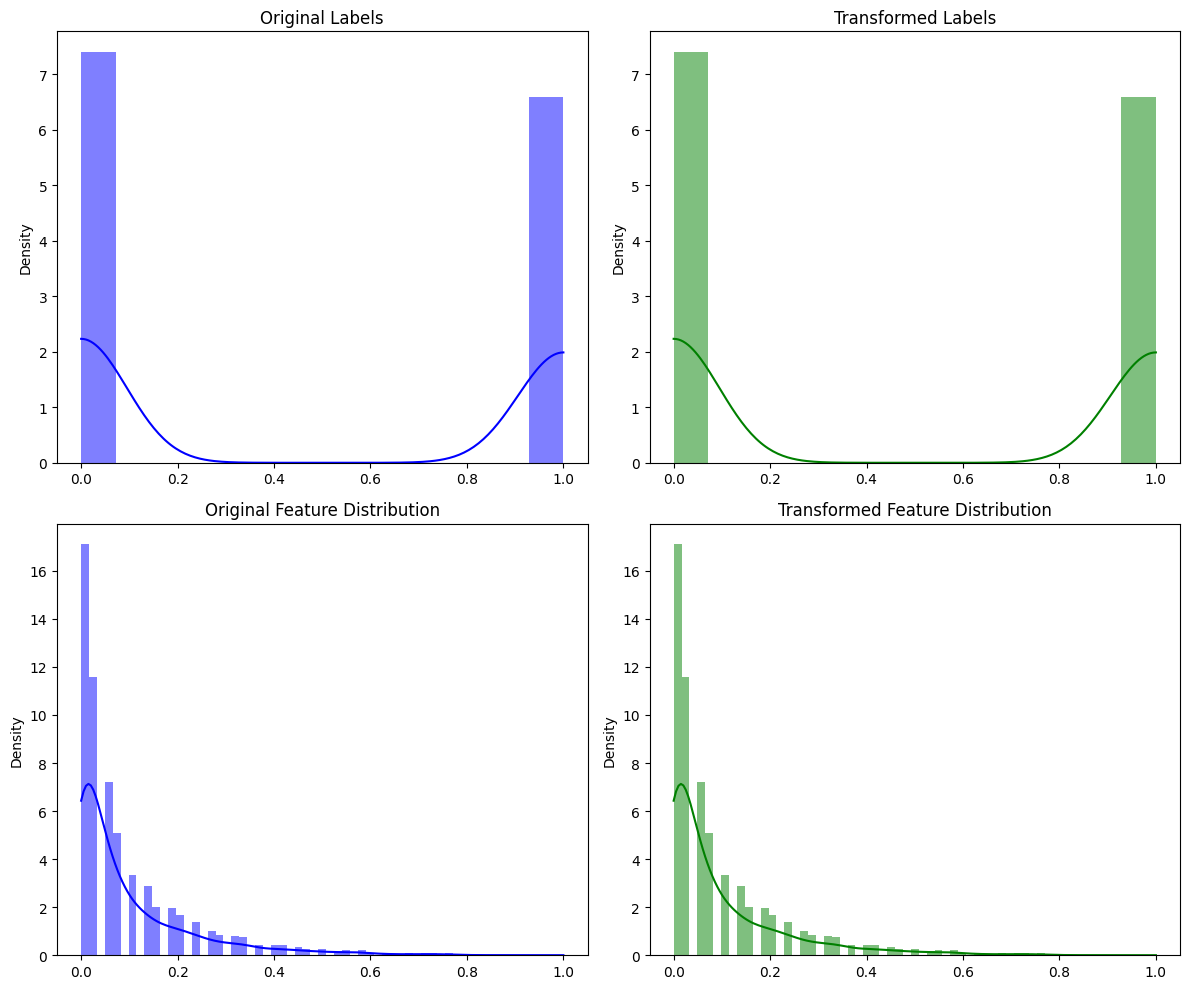

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'labels' and 'priors_count' (or another key feature) are of interest
# Extract these values from both datasets
original_labels = train.labels.ravel()
transformed_labels = transf_train.labels.ravel()

original_feature = train.features[:, train.feature_names.index('priors_count')]
transformed_feature = transf_train.features[:, transf_train.feature_names.index('priors_count')]

# Plotting distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot distribution of labels
sns.histplot(original_labels, ax=axes[0, 0], color="blue", kde=True, stat="density", linewidth=0)
axes[0, 0].set_title('Original Labels')
sns.histplot(transformed_labels, ax=axes[0, 1], color="green", kde=True, stat="density", linewidth=0)
axes[0, 1].set_title('Transformed Labels')

# Plot distribution of a key feature
sns.histplot(original_feature, ax=axes[1, 0], color="blue", kde=True, stat="density", linewidth=0)
axes[1, 0].set_title('Original Feature Distribution')
sns.histplot(transformed_feature, ax=axes[1, 1], color="green", kde=True, stat="density", linewidth=0)
axes[1, 1].set_title('Transformed Feature Distribution')

plt.tight_layout()
plt.show()



# Train Logistic Regression with reweighed dataset

In [112]:

scale_transf = StandardScaler()
X_reweighed_train = scale_transf.fit_transform(transf_train.features)
y_reweighed_train = transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_reweighed_train, y_reweighed_train,
        sample_weight=transf_train.instance_weights)
y_train_pred = lmod.predict(X_reweighed_train)

In [146]:
transf_test = RW.transform(test)

scale_transf = StandardScaler()
X_reweighed_test = scale_transf.fit_transform(transf_test.features)
y_reweighed_test = transf_test.labels.ravel()

# Predict on test
y_pred = lmod.predict(X_reweighed_test)
X_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.27655987,
        0.40499307],
       [0.        , 0.5       , 1.        , ..., 0.        , 0.78583474,
        0.82385576],
       [0.        , 1.        , 0.        , ..., 0.00960512, 0.08937605,
        0.24479889],
       ...,
       [0.        , 0.5       , 0.        , ..., 0.00106724, 0.0143339 ,
        0.18862691],
       [0.        , 0.        , 0.        , ..., 0.00106724, 0.91905565,
        0.93273232],
       [1.        , 0.5       , 0.        , ..., 0.02454642, 0.54131535,
        0.60679612]])

In [162]:
# Create boolean masks for African-American and Caucasian groups
# Make sure these masks are created from the dataset used for the predictions
afr_am_mask = (transf_test.features[:, 0] == 0)
white_mask = (transf_test.features[:, 0] == 1)

# Apply the masks to the predictions
pred_afr_am = y_pred[afr_am_mask]
pred_white = y_pred[white_mask]

# Calculate the Black to White Prisoners Ratio
# Count of African-American individuals divided by count of Caucasian individuals
ratio_afr_am_white = np.sum(afr_am_mask) / np.sum(white_mask)

# Calculate the Predicted Reoffense Ratio for Blacks to Whites
# Sum of predicted reoffenses for African-Americans divided by sum for Caucasians
ratio_pred_reoffense = np.sum(pred_afr_am == 1) / np.sum(pred_white == 1)

print("Black to white prisoners ratio:", np.round(ratio_afr_am_white, 2))
print("Predicted reoffense blacks to whites ratio:", np.round(ratio_pred_reoffense, 2))


Black to white prisoners ratio: 1.5
Predicted reoffense blacks to whites ratio: 1.85


## As you can see, now the prediction is closer to the ratio

In [163]:
y_pred = lmod.predict(X_reweighed_test)

acc = np.sum(y_pred == y_reweighed_test) / len(y_reweighed_test)
print("Accuracy =", np.round(acc, 3))

Accuracy = 0.875


In [174]:

privileged_groups_new = [{protected: 1}]
unprivileged_groups_new = [{protected: 0}]


cm = BinaryLabelDatasetMetric(transf_test.copy(), # 
                              privileged_groups=privileged_groups_new, 
                              unprivileged_groups=unprivileged_groups_new)

DIs.append(cm.disparate_impact())

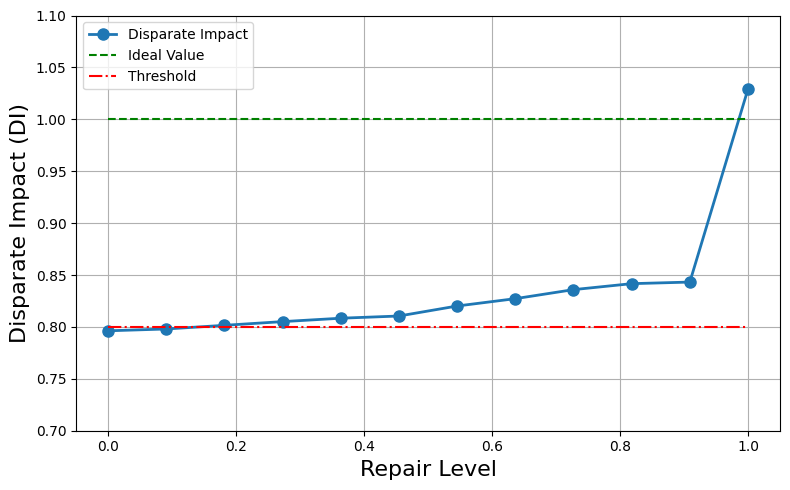

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming DIs is your list of disparate impact values with the appropriate length
plt.figure(figsize=(8, 5))

# Plot with increased marker size and line width
plt.plot(np.linspace(0, 1, 12), DIs, marker='o', markersize=8, linewidth=2, label='Disparate Impact')

# Green line for the ideal value of DI = 1
plt.plot([0, 1], [1, 1], 'g', linestyle='--', label='Ideal Value')

# Red line for threshold
plt.plot([0, 1], [0.8, 0.8], 'r', linestyle='-.', label='Threshold')

plt.ylim([0.7, 1.1])

# Setting font size for labels and title
plt.ylabel('Disparate Impact (DI)', fontsize=16)
plt.xlabel('Repair Level', fontsize=16)

# Adding grid, legend, and tight layout
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig('DisparateImpactFixed.png')

# Show the plot
plt.show()


### When we apply the reweighted dataset to train a model and subsequently calculate fairness metrics like Disparate Impact (DI), we typically expect the DI values to move towards 1, signaling reduced bias. The marked increase in DI at this full repair level indicates that the algorithm has substantially adjusted the instance weights, aiming to correct for disparities.

# Reject Option Classification (Post-processing)

The goal of this technique is to improve the fairness of predictions made by a classifier.

- **Classifier Prediction**: First, you have a classifier that has been trained on your dataset and makes predictions about new instances.

- **Confidence Interval**: Reject Option Classification operates on a confidence interval around the decision boundary of the classifier. This is where the classifier's certainty about its predictions is lower.

- **Protected Attribute**: It uses a protected attribute (like race or gender) to determine where bias might be present in these uncertain predictions.

- **Favorable Outcomes**: For instances within the confidence interval, if they belong to the unprivileged group, the algorithm can change an unfavorable outcome to a favorable one. Conversely, for the privileged group, it can change a favorable outcome to an unfavorable one.

- **Fairness Enhancement**: The idea is to "reject" the initial decision (hence the name) in favor of one that will lead to a more balanced distribution of positive outcomes between the privileged and unprivileged groups.

- **Balancing Performance and Fairness**: This method aims to balance the overall performance of the classifier (in terms of accuracy, precision, etc.) with fairness considerations. It seeks to ensure that the positive predictive value (the probability that subjects with a positive screening test truly have the disease) is similar across groups.

In [188]:
#Identifying the Favorable Outcome Index
pos_ind = np.where(lmod.classes_ == transf_train.favorable_label)[0][0] #We identify the favorable outcome index

#Fit the scaler on the training data and transform the training features
scale_transf = StandardScaler() #We fit the scaler on the training data and transform the training features
X_reweighed_train = scale_transf.fit_transform(transf_train.features) #We fit the scaler on the training data and transform the training features

#Transform the test features using the same scaler
X_reweighed_test = scale_transf.transform(transf_test.features) #We transform the test features using the same scaler

#Copy the datasets
transf_train_post = transf_train.copy() #We copy the datasets
transf_test_post = transf_test.copy() #We copy the datasets

#Predict probabilities and assign scores for the training and test sets
transf_train_post.scores = lmod.predict_proba(X_reweighed_train)[:, pos_ind].reshape(-1, 1) #We predict probabilities and assign scores for the training and test sets
transf_test_post.scores = lmod.predict_proba(X_reweighed_test)[:, pos_ind].reshape(-1, 1) #We predict probabilities and assign scores for the training and test sets


In [189]:
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

metric_ub = 0.05 #We set the upper bound for the metric
metric_lb = -0.05 #We set the lower bound for the metric

ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, #We set the upper bound for the metric
                                 privileged_groups=privileged_groups, #We set the lower bound for the metric
                                 low_class_thresh=0.01, #Range of decision thresholds to consider for potential adjustment.
                                 high_class_thresh=0.99, #Range of decision thresholds to consider for potential adjustment.
                                  num_class_thresh=100, #Number of decision thresholds to be considered within the specified range
                                  num_ROC_margin=50, #Number of margins to be examined around the decision threshold where ROC will adjust the classifier's predictions.
                                  metric_name= 'Statistical parity difference', #Metric used to measure fairness for determining thresholds
                                  metric_ub=metric_ub, metric_lb=metric_lb) #Upper and lower bound for the fairness metric used to determine thresholds
                                  
ROC = ROC.fit(transf_test, transf_test_post)

 It learns how to adjust the decision thresholds based on the scores and labels in transf_test_post such that the fairness metric (Statistical parity difference in this case) falls between the bounds specified earlier (metric_ub and metric_lb). The dataset transf_test is used as a reference for the original decision making, which transf_test_post presumably improves upon.



In [190]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.8217
Optimal ROC margin = 0.0146


ROC algorithm has identified 0.8217 as the decision threshold that best balances the classifier's performance with the fairness constraints that were set.
Optimal ROC margin = 0.0146. This margin is where the algorithm is most active in adjusting predictions to improve fairness. 

if an instance belonging to the unprivileged group has a score slightly below the threshold, it might be pushed above the threshold to receive a favorable outcome. Conversely, an instance from the privileged group with a score just above the threshold might be pulled below it to receive an unfavorable outcome

### Algorithm has found a way to adjust the classifier's predictions to conform to the fairness constraints without excessively compromising its predictive performance

The purpose of this function is to evaluate the performance of a classification model from both a standard accuracy perspective and a fairness perspective

In [194]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp=True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true, dataset_pred, 
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)
    # Initialize an empty OrderedDict
    # Compute all required metrics at once
    metrics = OrderedDict([
        ("Balanced accuracy", 0.5 * (classified_metric_pred.true_positive_rate() + 
                                     classified_metric_pred.true_negative_rate())),
        ("Statistical parity difference", classified_metric_pred.statistical_parity_difference()),
        ("Disparate impact", classified_metric_pred.disparate_impact()),
        ("Average odds difference", classified_metric_pred.average_odds_difference()),
        ("Equal opportunity difference", classified_metric_pred.equal_opportunity_difference()),
        ("Theil index", classified_metric_pred.theil_index())
    ])
    
    if disp:
        # Display metrics in a formatted way
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name} = {metric_value:.4f}")
    
    return metrics


In [195]:
# Metrics for the transformed test set
dataset_transf_test_post = ROC.predict(transf_test_post)


In [196]:
metric_test_aft = compute_metrics(transf_test, dataset_transf_test_post, 
                unprivileged_groups, privileged_groups)

Balanced accuracy = 0.8963
Statistical parity difference = -0.0066
Disparate impact = 0.9852
Average odds difference = -0.0173
Equal opportunity difference = -0.0381
Theil index = 0.1148


**Balanced Accuracy (0.8963)** :

Good overall accuracy of the model. Balanced accuracy takes into account both the true positive rate and true negative rate.

**Statistical Parity Difference (-0.0066)**

 It indicates that the probability of a positive outcome (favorable prediction) is nearly equal for both privileged and unprivileged groups

**Disparate Impact (0.9852)**

A value close to 1 indicates fair treatment between the groups. Specifically, a value of 1 would imply perfect fairness. The model's predictions do not disproportionately favor one group over the other

**Average Odds Difference (-0.0173)**

Equality of odds between unprivileged and privileged groups. A value of 0 would mean perfect equality. The value -0.0173 indicates a small bias against the unprivileged group in terms of false positive and true positive rates, but this bias is relatively minor now.

**Equal Opportunity Difference (-0.0381)**

True positive rates between groups. A value of 0 represents equal opportunity. The value -0.0381 suggests a slight bias against the unprivileged group in terms of having true positives or favorable outcomes.

**Theil Index (0.1148)**

Theil index is a measure of inequality. A value of 0 indicates perfect equality, while higher values show greater inequality. A value of 0.1148 indicates some inequality in the model's predictions, but it's not excessively high


# References:

[AI Fairness 360 (AIF360) Documentation](https://aif360.readthedocs.io/en/latest/Getting%20Started.html)

[AI Fairness 360 (AIF360) DisparateImpactRemover](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html#id2)

[ProPublica. (n.d.). COMPAS Recidivism Risk Score Data and Analysis. ProPublica Data Store. Retrieved from https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis)
